# Building Your First Cluster
In this guide, we will demonstrate how to make your own galaxy cluster model using the ``ClusterModel`` class. The ``ClusterModel`` class is essentially a data container which holds all of the "fields" (density, temperature, etc.) related to that galaxy cluster. Fields can be accessed directly using the ``ClusterModel.fields`` attribute, and are stored as ``unyt_arrays`` so that they can carry units. Generally, ``ClusterModel`` instances are generated from just 1 or 2 known ``RadialProfile`` objects, and then the backend computes the remaining fields of interest behind the scenes. Let's see this in action. The first step is to make the radial profiles:

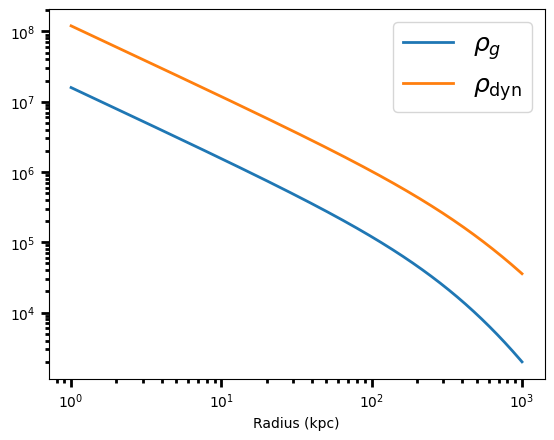

In [1]:
# imports #
import cluster_generator as cg
import numpy as np
import matplotlib.pyplot as plt
# making the radial profiles #
dens = cg.hernquist_density_profile(1e14,1000) # The gas density profile
tden = cg.nfw_density_profile(1e5,1200) # The total density

fig = plt.figure()
ax = fig.add_subplot(111)
dens.plot(1,1000,fig=fig,ax=ax,label=r"$\rho_g$")
tden.plot(1,1000,fig=fig,ax=ax,label=r"$\rho_{\mathrm{dyn}}$")
plt.legend()
plt.show()

Once we have the radial profiles ready to go, its time to make the actual model.


In [2]:
# Making the ClusterModel object #
dens_tden_model = cg.model.ClusterModel.from_dens_and_tden(1,10000,dens,tden,stellar_density=None,num_points=5000,gravity="Newtonian")

cluster_generator : [INFO     ] 2023-08-23 09:09:09,795 Computing the profiles from density and total density. Gravity=Newtonian
cluster_generator : [INFO     ] 2023-08-23 09:09:09,800 Integrating total mass profile.
cluster_generator : [INFO     ] 2023-08-23 09:09:09,983 ClusterModel [ClusterModel object; gravity=Newtonian] has no virialization method. Setting to default = eddington
cluster_generator : [INFO     ] 2023-08-23 09:09:09,985 Computing gravitational potential of ClusterModel object; gravity=Newtonian. gravity=Newtonian.
cluster_generator : [INFO     ] 2023-08-23 09:09:09,986 Computation of potential is using mdr for computation.
cluster_generator : [INFO     ] 2023-08-23 09:09:13,832 Integrating pressure profile.
cluster_generator : [INFO     ] 2023-08-23 09:09:25,339 ClusterModel [ClusterModel object; gravity=Newtonian] has no virialization method. Setting to default = eddington


Let's go through this output because it tells us alot about what's going on behind the scenes. The first line tells us that we are generated a ``ClusterModel`` object from density and total density. There are also other ways to generate galaxy cluster models. For example, ``cg.model.ClusterModel.from_dens_and_temp`` and ``cg.model.ClusterModel.from_dens_and_entr`` both allow the user to generate ``ClusterModel`` objects from temperature and entropy profiles respectively. The next 5 lines of the output are all about filling in the blanks where we need to compute fields not explicitly provided by the user. In this specific case, the backend is integrating to determine masses, and then passing to the Poisson solver to determine the potential. 

The final line of the output is more interesting. Every ``ClusterModel`` object has a ``ClusterModel.virialization_method`` which determines how ``cluster_generator`` computes the velocity distribution of halo particles. We'll talk more about this later. For now, let's look at what comes out on the other side of the construction process!

In [3]:
print(dens_tden_model)

ClusterModel object; gravity=Newtonian, fields=['radius', 'density', 'total_density', 'total_mass', 'gas_mass', 'stellar_density', 'gravitational_potential', 'gravitational_field', 'pressure', 'temperature', 'dark_matter_density', 'dark_matter_mass', 'gas_fraction', 'electron_number_density', 'entropy']


That's a lot of fields! To access any of the data, you can either use ``dens_tden_model["field-name"]`` or ``dens_tden_model.fields["field-name"]``. Let's try plotting some of the data!

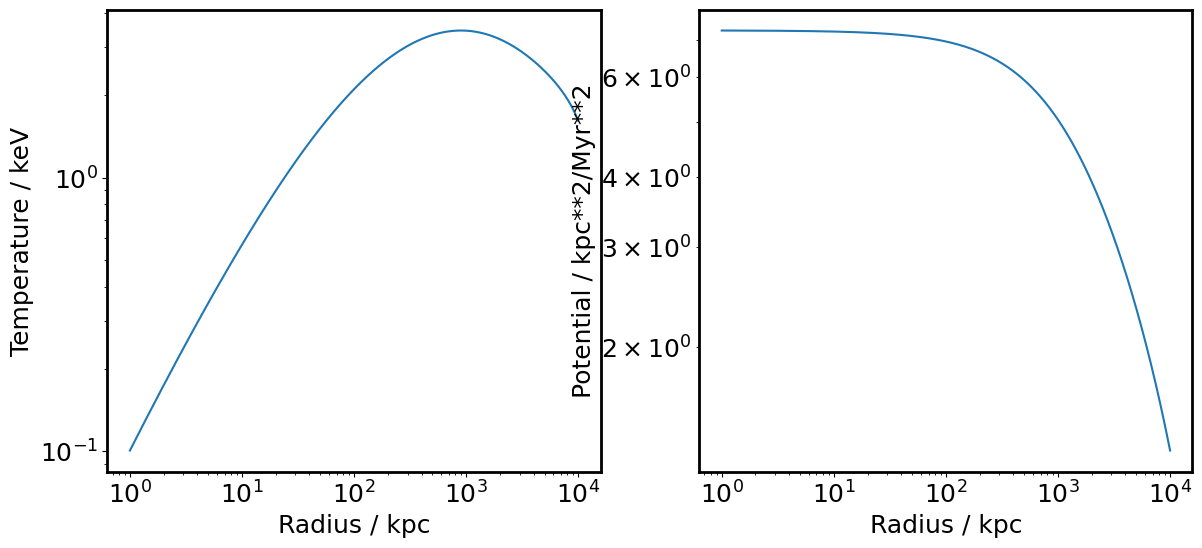

In [4]:
# pull out the data #
rr = dens_tden_model["radius"]
temp = dens_tden_model["temperature"]
pot = dens_tden_model["gravitational_potential"]
# plotting #
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.loglog(rr.d,temp.d)

ax1.set_xlabel(f"Radius / {rr.units}")
ax1.set_ylabel(f"Temperature / {temp.units}")

ax2.loglog(rr.d,np.abs(pot.d))
ax2.set_xlabel(f"Radius / {rr.units}")
ax2.set_ylabel(f"Potential / {pot.units}")
plt.show()

## Checking Out the Cluster
Okay, so we have a galaxy cluster but we probably want to make sure it's behaving well before moving on. There are two methods for checking on ``ClusterModels``: ``.is_physical`` and ``.check_hse``. The ``.is_physical`` method checks that none of the density profiles or temperature profiles becomes non-physical. The ``.check_hse()`` method checks to make sure that the galaxy cluster remains in hydrostatic equilibrium. Let's try them out:

In [7]:
is_phys = dens_tden_model.is_physical()
check_hse = dens_tden_model.check_hse()


✔ cluster_generator : [INFO     ] Wed Aug 23 09:10:04 2023 Checking physicality ⠙ luster_generator : [INFO     ] Wed Aug 23 09:10:04 2023 Checking physicality o ClusterModel object; gravity=Newtonian is physical.
cluster_generator : [INFO     ] 2023-08-23 09:10:04,795 The maximum relative deviation of this profile from hydrostatic equilibrium is 1.76071e-06


Awesome, our entire cluster makes logical sense! Now, let's move onto some more advanced aspects of the model.

## Virializing Your Cluster
Okay, so you've got a ``ClusterModel`` generated and now you want to figure out the halo particle's velocity distribution so that you can initialize them in an N-body code? ``cluster_generator`` makes the process really simple. The first step is to choose how we want to virialize the cluster. There are two options: Eddington's Formula or the Local Maxwellian Approximation. In this case, we can check out both, but the user should do some reading to figure out which best suits their needs.


In [10]:
# virializing #
print(f"The virialization method is: {dens_tden_model.virialization_method}.")

vir = dens_tden_model.dm_virial

The virialization method is: eddington.


Computing particle DF (Eddington) :   0%|          | 0/5000 [00:00<?, ?it/s]

Okay, so what's happened here? We figured out that our ``ClusterModel`` is using ``eddington`` as the virialization method. It turns out that ``cluster_generator`` figures this out automatically depending on what ``gravity`` you select for the ``ClusterModel``. You can always change it afterwards. Now, the ``vir`` object is a new class: the ``VirialEquilibrium`` class. The user almost never needs to actually interact with this class, but it's constructed to house all of the machinery for solving the virialization problem. What is useful is that now we can access the distribution function (see Binney / Tremaine) of our cluster:


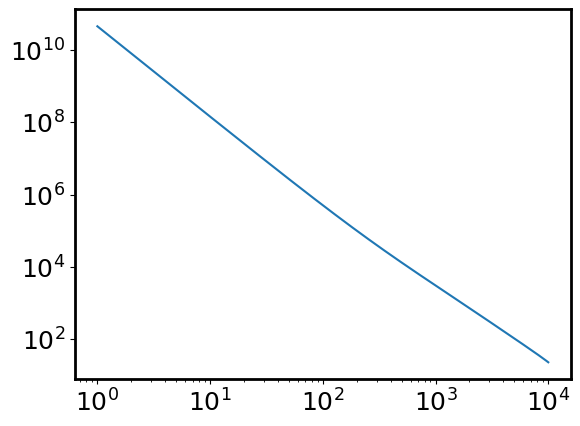

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.loglog(dens_tden_model["radius"].d,vir.df)
plt.show()

We can also check that the ``VirialEquilibrium`` object is correct by calling

cluster_generator : [INFO     ] 2023-08-23 09:25:30,224 The maximum relative deviation of this profile from virial equilibrium is 17.3225


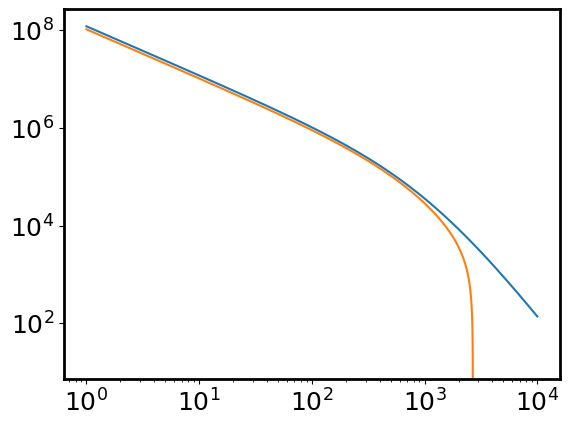

In [16]:
rho,check = dens_tden_model.check_dm_virial()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.loglog(dens_tden_model["radius"].d,dens_tden_model["total_density"].d)
ax.loglog(dens_tden_model["radius"].d,rho)

plt.show()

## Generating Particles

## Saving Models to Disk
